# Facial Recognition using Convolutional Neural Network & TensarFlow(GPU).

Note : For transfer learning use cnn.json file.(Pre-trained) <br>
Importing all dependant packages of python library keras for Convolutional Neural Network, we are using TensarFlow in background.


In [1]:
%%time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Activation
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
%matplotlib inline

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


CPU times: user 1.76 s, sys: 1.58 s, total: 3.34 s
Wall time: 1.6 s


In [2]:
%%time
data = pd.read_csv("fer2013.csv")
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
emotion    35887 non-null int64
pixels     35887 non-null object
Usage      35887 non-null object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB
CPU times: user 2.51 s, sys: 268 ms, total: 2.78 s
Wall time: 2.78 s


In [3]:
%%time
data["Usage"].value_counts()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.72 ms


Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [4]:
%%time
# we begin to split the dataset into Training nnd Test
tr = data[["emotion", "pixels"]][data["Usage"] == "Training"] #training set 
tr.isnull().sum()

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 10.2 ms


In [5]:
%%time
tr['pixels'] = tr['pixels'].apply(lambda im: np.fromstring(im, sep=' ')) #splitting pixels by space delimiter
x_tr = np.vstack(tr['pixels'].values) #storing pixels into x_tr variable
y_tr = np.array(tr["emotion"]) #storing emotion into y_tr variable
#x_tr.shape, y_tr.shape

CPU times: user 10.2 s, sys: 400 ms, total: 10.6 s
Wall time: 10.6 s


In [6]:
test_data = data[["emotion", "pixels"]][data["Usage"]=="PublicTest"] # Now take test dataset,split for PublicTest 

In [7]:
%%time
test_data["pixels"] = test_data["pixels"].apply(lambda im: np.fromstring(im, sep=' ')) #splitting test set pixels by space delimiter 
x_te = np.vstack(test_data["pixels"].values) #storing pixels into x_te variable
y_te = np.array(test_data["emotion"]) #storing emotion into y_te variable

CPU times: user 1.32 s, sys: 44 ms, total: 1.36 s
Wall time: 1.36 s


In [8]:
# Let's reshape the variable into 48*48 metrix
x_tr = x_tr.reshape(-1, 48, 48, 1) #reshaping x_train into 48*48
x_te = x_te.reshape(-1, 48, 48, 1) #reshaping x_test into 48*48
#x_tr.shape, x_te.shape

In [9]:
y_tr = np_utils.to_categorical(y_tr) # converting to categorical values
y_te = np_utils.to_categorical(y_te)

### Building a model

#### The Model follows below structure:<br>
`Initiate Module` > `Convolution & Relu layer` > `Max pooling layer` > `Batch Normalization` >`Dropout layer` > `Ddense layer` > `Dropout layer` > `Fully connected dense layer` > `Classifier`


![](con.png)
Image Ref. = https://blog.dataiku.com/deep-learning-with-dss

In [10]:
%%time
cnn = Sequential()

# Now, describe layers, first layer is always convolutional layer 

cnn.add(Conv2D(64, 3, data_format="channels_last", kernel_initializer="he_normal", 
                 input_shape=(48, 48, 1))) #Specifying the input shape
cnn.add(BatchNormalization()) #Batch normalization layer: normalize the input layer by adjusting and scaling the activations
cnn.add(Activation("relu")) # And the Activation function

cnn.add(Conv2D(64, 3))
cnn.add(BatchNormalization())
cnn.add(Activation("relu"))
cnn.add(MaxPool2D(pool_size=(2, 2), strides=2)) # down-sample an input representation by reducing its dimensionality
cnn.add(Dropout(0.6)) # regularization technique which prevents over-fitting of the network.

cnn.add(Conv2D(32, 3)) 
cnn.add(BatchNormalization())
cnn.add(Activation("relu"))

cnn.add(Conv2D(32, 3))
cnn.add(BatchNormalization())
cnn.add(Activation("relu"))

cnn.add(Conv2D(32, 3))
cnn.add(BatchNormalization())
cnn.add(Activation("relu"))
cnn.add(MaxPool2D(pool_size=(2, 2), strides=2))
cnn.add(Dropout(0.6))

#Flattens the input. Does not affect the batch size.
cnn.add(Flatten())
cnn.add(Dense(128))
cnn.add(BatchNormalization())
cnn.add(Activation("relu"))
cnn.add(Dropout(0.6))

cnn.add(Dense(7))
cnn.add(Activation('softmax'))
#Before training a model, we need to configure the learning process, which we are doing via compile method. 
#three arguments loss, optimizer, metrics
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

CPU times: user 836 ms, sys: 276 ms, total: 1.11 s
Wall time: 1.1 s


In [11]:
%%time
# now, create a checkpoint and shave all the best weights
save_weights = ModelCheckpoint(filepath='checkpoint_weights.h5', verbose=1, save_best_only=True)
epochs = 100

# run the model
runm = cnn.fit(x_tr, y_tr, epochs=epochs,
                 shuffle=True,
                 batch_size=100, validation_data=(x_te, y_te),
                 callbacks=[save_weights], verbose=2)

# This is the most important part, as model takes long time to train, we saved model to the json file which can be used as transfered learning so that we can use it next time without need to train the model again
cnn_json = cnn.to_json()
with open("cnn.json", "w") as json_file:
    json_file.write(cnn_json)

Train on 28709 samples, validate on 3589 samples
Epoch 1/100
 - 20s - loss: 1.9774 - acc: 0.2622 - val_loss: 1.5909 - val_acc: 0.3945

Epoch 00001: val_loss improved from inf to 1.59092, saving model to checkpoint_weights.h5
Epoch 2/100
 - 17s - loss: 1.6410 - acc: 0.3570 - val_loss: 1.4860 - val_acc: 0.4296

Epoch 00002: val_loss improved from 1.59092 to 1.48601, saving model to checkpoint_weights.h5
Epoch 3/100
 - 17s - loss: 1.5285 - acc: 0.4047 - val_loss: 1.4232 - val_acc: 0.4458

Epoch 00003: val_loss improved from 1.48601 to 1.42320, saving model to checkpoint_weights.h5
Epoch 4/100
 - 17s - loss: 1.4531 - acc: 0.4393 - val_loss: 1.3705 - val_acc: 0.4681

Epoch 00004: val_loss improved from 1.42320 to 1.37047, saving model to checkpoint_weights.h5
Epoch 5/100
 - 17s - loss: 1.4044 - acc: 0.4607 - val_loss: 1.3018 - val_acc: 0.4946

Epoch 00005: val_loss improved from 1.37047 to 1.30184, saving model to checkpoint_weights.h5
Epoch 6/100
 - 17s - loss: 1.3603 - acc: 0.4779 - val_l


Epoch 00055: val_loss did not improve
Epoch 56/100
 - 17s - loss: 1.0078 - acc: 0.6168 - val_loss: 1.0691 - val_acc: 0.5946

Epoch 00056: val_loss did not improve
Epoch 57/100
 - 17s - loss: 0.9982 - acc: 0.6218 - val_loss: 1.0301 - val_acc: 0.6099

Epoch 00057: val_loss did not improve
Epoch 58/100
 - 17s - loss: 0.9947 - acc: 0.6240 - val_loss: 1.0555 - val_acc: 0.5968

Epoch 00058: val_loss did not improve
Epoch 59/100
 - 17s - loss: 0.9950 - acc: 0.6230 - val_loss: 1.0724 - val_acc: 0.5957

Epoch 00059: val_loss did not improve
Epoch 60/100
 - 17s - loss: 0.9944 - acc: 0.6230 - val_loss: 1.0272 - val_acc: 0.6183

Epoch 00060: val_loss improved from 1.02738 to 1.02724, saving model to checkpoint_weights.h5
Epoch 61/100
 - 17s - loss: 0.9895 - acc: 0.6290 - val_loss: 1.0233 - val_acc: 0.6110

Epoch 00061: val_loss improved from 1.02724 to 1.02329, saving model to checkpoint_weights.h5
Epoch 62/100
 - 17s - loss: 0.9882 - acc: 0.6268 - val_loss: 1.0292 - val_acc: 0.6108

Epoch 00062:

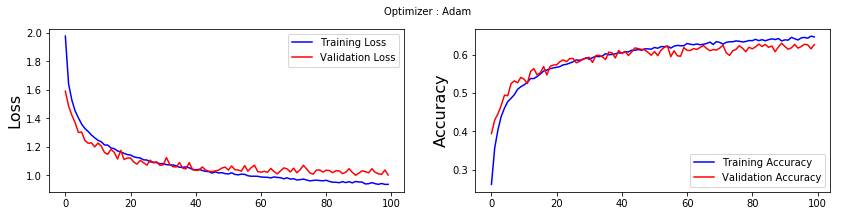

In [12]:
#plotting Loss
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(runm.history['loss'], color='b', label='Training Loss')
plt.plot(runm.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

#plotting accuracy
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(runm.history['acc'], color='b', label='Training Accuracy')
plt.plot(runm.history['val_acc'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [13]:
# test the model on test set
run_te = data[["emotion", "pixels"]][data["Usage"] == "PrivateTest"]
run_te["pixels"] = run_te["pixels"].apply(lambda im: np.fromstring(im, sep=' '))
run_te.head()

,emotion,pixels
32298,0,"[170.0, 118.0, 101.0, 88.0, 88.0, 75.0, 78.0, ..."
32299,5,"[7.0, 5.0, 8.0, 6.0, 7.0, 3.0, 2.0, 6.0, 5.0, ..."
32300,6,"[232.0, 240.0, 241.0, 239.0, 237.0, 235.0, 246..."
32301,4,"[200.0, 197.0, 149.0, 139.0, 156.0, 89.0, 111...."
32302,2,"[40.0, 28.0, 33.0, 56.0, 45.0, 33.0, 31.0, 78...."


In [14]:
# calculating the scores
x_te_score = np.vstack(run_te["pixels"].values)
y_te_score = np.array(run_te["emotion"])

In [15]:
x_te_score = x_te_score.reshape(-1, 48, 48, 1)
y_te_score = np_utils.to_categorical(y_te_score)
x_te_score.shape, y_te_score.shape

((3589, 48, 48, 1), (3589, 7))

In [16]:
score = cnn.evaluate(x_te_score, y_te_score)
score

3589/3589 [==============================] - 1s 264us/step


[0.985946317176096, 0.6336026748480921]

In [17]:
print( "Score : ", score[0])
print ("Accuracy : ", score[1]*100)

Score :  0.985946317176096
Accuracy :  63.36026748480921


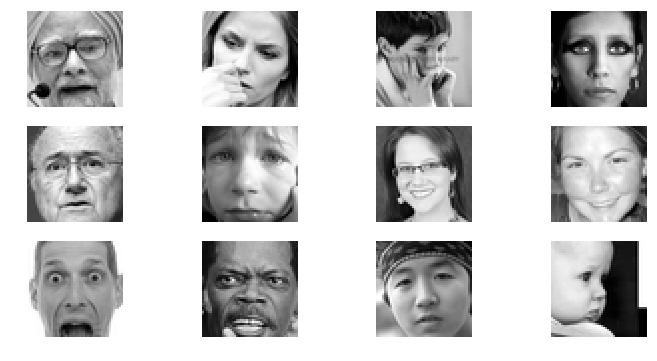

CPU times: user 476 ms, sys: 352 ms, total: 828 ms
Wall time: 395 ms


In [18]:
%%time
# Lets display some images here,
plt.figure(0, figsize=(12,6))
for i in range(1, 13):
    plt.subplot(3,4,i)
    plt.imshow(x_tr[i, :, :, 0], cmap="gray") # now lets display images from dataset
    plt.axis('off')
plt.show()

#### API references for CNN: 

1. Keras Sequential model: https://keras.io/getting-started/sequential-model-guide/
2. Dropout : https://keras.io/layers/core/#dropout
3. Conv2D : https://keras.io/layers/convolutional/#convolution2d
4. MaxPool2D : https://keras.io/layers/pooling/#maxpooling2d
5. Dense : https://keras.io/layers/core/#dense
6. Flatten : https://keras.io/layers/core/#flatten
